# Lista 6

## Uczenie maszynowe i sztuczna inteligencja

## Wstęp
**Na tej liście przejdziemy do wykorzystywania rekurencyjnych sieci neuronowych. Zadania sprowadzają się do analizy istniejącego kodu oraz uzupełnienia implementacji oraz przeprowadzenia dodatkowych eksperymentów.**

# Zadanie 1 (15pt)


W tym zadaniu przeanalizujemy różne metody uczenia się na podstawie danych sekwencyjnych.

Powtarzającym się przykładem będzie szkolenie sieci neuronowych w zakresie modelowania języka, czyli przewidywania kolejnego tokenu w zdaniu. W kontekście przetwarzania języka naturalnego tokenem może być znak lub słowo, należy jednak pamiętać, że wprowadzone tutaj koncepcje odnoszą się do wszelkiego rodzaju danych sekwencyjnych, takich jak np.: sygnały audio lub filmy

Aby naprawdę zrozumieć, co dzieje się w rekurencyjnej sieci neuronowej (RNN), znaczną część tego zadania przeprowadzimy w NumPy, a nie w PyTorch lub Kerasie. Zaczynamy od prostego problemu, zbudujemy RNN za pomocą NumPy, trenujemy i przekonamy się, że to naprawdę działa. Gdy będziemy już przekonani, przystępujemy do budowania i uczenia komórki pamięci długoterminowej (LSTM). Celem tego zadania jest po prostu zapewnienie głębszego zrozumienia uczenia RNN. Gdy zrozumiesz wewnętrzne działanie RNN, przejdziemy do implementacji PyTorch, której będzie można używać w pozostałej części listy.

Podsumowując, w tym zadaniu nauczymy się:
* Jak reprezentować ciągi zmiennych kategorycznych
* Jak zbudować i wytrenować RNN w NumPy
* Jak zbudować i trenować sieć RNN i LSTM w PyTorch

Duża część poniższej implementacji została zainspirowana implementacją napisaną przez [Andrej Karpathy](https://karpathy.ai/).

## Reprezentowanie tokenów lub tekstu

W poprzednich laboratoriach rozważaliśmy głównie dane $x \in \mathrm{R}^d$, gdzie $d$ to wymiar przestrzeni cech.
W przypadku sekwencji czasowych nasze dane można przedstawić jako $x \in \mathrm{R}^{t \, \times \, d}$, gdzie $t$ to długość sekwencji. 
Podkreśla to zależność sekwencji i fakt, że próbki wzdłuż sekwencji nie są niezależne i o jednakowym rozkładzie (i.i.d.).
Będziemy modelować funkcje jako $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, gdzie $c$ to liczba klas na wyjściu.

Istnieje kilka sposobów przedstawiania sekwencji. W przypadku tekstu wyzwanie polega na tym, jak przedstawić słowo jako wektor cech w $d$ wymiarach, ponieważ musimy reprezentować tekst za pomocą liczb dziesiętnych, aby zastosować do niego sieci neuronowe.

W tym zadaniu użyjemy prostego kodowania typu one-hot, ale w przypadku zmiennych kategoryzacyjnych, które mogą przyjmować wiele wartości (np. słów w języku angielskim), może to być niewykonalne. W takich scenariuszach można rzutować kodowanie na mniejszą przestrzeń za pomocą osadzania (embeddings).

## Generowanie zbioru danych

Na potrzeby tego ćwiczenia utworzymy prosty zbiór danych, z którego będziemy mogli się uczyć. Generujemy ciągi postaci:

`a b EOS`,

`a a b b EOS`,

`a a a a b b b b b EOS`

gdzie „EOS” jest znakiem specjalnym oznaczającym koniec sekwencji. Zadanie polega na przewidzeniu kolejnego tokena $t_n$, czyli `a`, `b`, `EOS` lub nieznanego tokena `UNK` na podstawie ciągu tokenów $\{ t_{1}, t_{2}, \ kropki , t_{n-1}\}$, a sekwencje mamy przetwarzać szeregowo. W związku z tym sieć będzie musiała nauczyć się, że m.in. 5 „b” i token „EOS” pojawią się po 5 „a”.

In [6]:
import numpy as np

np.random.seed(42)

def generate_dataset(num_sequences=2**8):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 12)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)        
    return samples


sequences = generate_dataset()

print('Pojedyncza wygenerowana próbka:')
print(sequences[:10])

Pojedyncza wygenerowana próbka:
[['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']]


## Reprezentowanie tokenów jako indeksów

Aby zbudować kodowanie typu one-hot, musimy każdemu możliwemu słowu w naszym słowniku przypisać indeks. Robimy to tworząc dwa słowniki: jeden, który pozwala nam przejść od danego słowa do odpowiadającego mu indeksu w naszym słowniku, oraz drugi, który pozwala nam przejść w odwrotnym kierunku. Nazwijmy je `word_to_idx` i `idx_to_word`. Słowo kluczowe `vocab_size` określa maksymalny rozmiar naszego słownictwa. Jeśli spróbujemy uzyskać dostęp do słowa, które nie istnieje w naszym słowniku, zostanie ono automatycznie zastąpione tokenem „UNK” lub odpowiadającym mu indeksem.

In [7]:
from collections import defaultdict

def flatten(l):
    return [item for sublist in l for item in sublist]

def sequences_to_dicts(_sequences):
    def make_word_count():
        word_count = defaultdict(int)
        for word in flatten(_sequences):
            word_count[word] += 1
        return sorted(list(word_count.items()), key=lambda l: l[1], reverse=True)
    
    word_count = make_word_count()

    unique_words = [item[0] for item in word_count] + ['UNK']
    
    num_sentences, vocab_size = len(_sequences), len(unique_words)
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')
    for idx, word in enumerate(unique_words):
        # TWOJ KOD TUTAJ!
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'Mamy {num_sequences} zdań i {len(word_to_idx)} unikatowych tokenów.\n')
print('Indeks \'b\' to', word_to_idx['b'])
print(f'Odpowiednik słowa dla indeksu 1 to \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Błąd: sprawdź implementacje.'

Mamy 256 zdań i 4 unikatowych tokenów.

Indeks 'b' to 1
Odpowiednik słowa dla indeksu 1 to 'b'


## Partycjonowanie zbioru danych

Aby zbudować nasz zbiór danych, musimy stworzyć dane wejściowe i cele dla każdej sekwencji i podzielić je na zbiory treningowe, walidacyjne i testowe. 80%, 10% i 10% to powszechny rozkład, ale pamiętaj, że zależy to w dużej mierze od rozmiaru zbioru danych. Ponieważ przewidujemy następne słowo, naszą sekwencją docelową jest po prostu sekwencja wejściowa przesunięta o jedno słowo. Wykorzystujemy tutaj klasę `Dateset` z`Torch` patrz [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).


In [15]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        X = self.inputs[index]
        y = self.targets[index]
        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # TUTAJ TWOJ KOD!
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train + num_val]
    sequences_test = sequences[num_train + num_val:num_train + num_val + num_test]


    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets

    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'Mamy {len(training_set)} próbek w zbiorze treningowym.')
print(f'Mamy {len(validation_set)} próbek w zbiorze walidacyjnym.')
print(f'Mamy {len(test_set)} próbek w zbiorze testowym.')

Mamy 204 próbek w zbiorze treningowym.
Mamy 25 próbek w zbiorze walidacyjnym.
Mamy 25 próbek w zbiorze testowym.


## Kodowanie One-Hot

Tworzymy teraz prostą funkcję, która zwraca zakodowaną w jednym miejscu reprezentację danego indeksu słowa w naszym słowniku. Zauważ, że wymiar kodowania one-hot jest równy całemu słownikowi (który może być ogromny!). Dodatkowo definiujemy funkcję automatycznego kodowania zdania na one-hot.

In [16]:
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1  
    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    # Tworzenie macierzy one-hot dla każdego słowa w sekwencji
    encoding = np.array(
        [
            one_hot_encode(
                word_to_idx[word] 
                if word in word_to_idx else word_to_idx['UNK'], 
                vocab_size
            ) for word in sequence
        ]
    )
    # Zmiana kształtu macierzy, aby pasowała do oczekiwanej struktury (dodanie dodatkowego wymiaru)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Nasze kodowanie one-hot słowo \'a\' ma wymiar {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Nasze kodowanie one-hot zdania \'a b\' ma wymiar {test_sentence.shape}.')

Nasze kodowanie one-hot słowo 'a' ma wymiar (4,).
Nasze kodowanie one-hot zdania 'a b' ma wymiar (2, 4, 1).


## Rekurencyjne Sieci Neuronowe RNN

Sieć definiujemy podobnie jak na wykładzie dla wygody zmienimy tylko trochę nazwy wag.
Sieć zawiera następujące elementy:

- $x$ to sekwencja wejściowa próbek, 
- $U$ to macierz wag zastosowana do danej próbki wejściowej,
- $V$ to macierz wag używana do obliczeń rekurencyjnych w celu przekazania pamięci wzdłuż sekwencji,
- $W$ to macierz wag używana do obliczania wyniku każdego kroku czasowego (biorąc pod uwagę, że każdy krok czasowy wymaga wyjścia),
- $h$ to stan ukryty (pamięć sieci) dla danego kroku czasowego, oraz
- $o$ to wynikowy wynik.

Sieć wykonujemy następujące obliczenia

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, gdzie $f$ jest nieliniową funkcją aktywacji, np. $\mathrm{tanh}$.
- $o_t = W\,{h_t}$

Kiedy modelujemy język przy użyciu straty entropii krzyżowej, dodatkowo stosujemy funkcję softmax do wyniku $o_{t}$:

- $\hat{y}_t = \mathrm{softmax}(o_{t})$

## Implementacja RNN

In [17]:
hidden_size = 50
vocab_size  = len(word_to_idx)

# Bardzo ważne dla sieci rekurencyjnych!
# https://arxiv.org/abs/1312.6120
def init_orthogonal(param):
    rows, cols = param.shape
    new_param = np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

def init_rnn(hidden_size, vocab_size):
    # Macierz U: transformuje wejście na rozmiar stanu ukrytego,
    # wymiary (hidden_size, vocab_size) pozwalają na połączenie każdego słowa ze stanem ukrytym
    U = np.zeros((hidden_size, vocab_size))

    # Macierz V: zapewnia rekurencyjne przekazywanie informacji o poprzednim stanie ukrytym do nowego stanu,
    # wymiary (hidden_size, hidden_size) umożliwiają transformację z jednego stanu ukrytego do kolejnego
    V = np.zeros((hidden_size, hidden_size))

    # Macierz W: przekształca stan ukryty na wyjściowe logity/punkty wynikowe, które są następnie przetwarzane przez softmax,
    # wymiary (vocab_size, hidden_size) pozwalają na mapowanie stanu ukrytego na prawdopodobieństwa słów
    W = np.zeros((vocab_size, hidden_size))

    # Bias b_hidden: dodaje dodatkowy element regulacji do każdego neuronu w warstwie ukrytej,
    # długość (hidden_size,) odpowiada liczbie neuronów w warstwie ukrytej
    b_hidden = np.zeros((hidden_size, 1))

    # Bias b_out: dodaje dodatkowy element regulacji do każdego wynikowego neuronu,
    # długość (vocab_size,) odpowiada liczbie potencjalnych wynikowych słów/kategorii
    b_out = np.zeros((vocab_size, 1))
    
    # Inicjalizacja ortogonalna dla U, V, W, zgodnie z rekomendacjami naukowymi dla RNN
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)



    # Zobacz jak będzie się uczyła sieć jak wykorzystamy prostą inicjalizację
    # przez rozkład jednostajny! lub normalny (randn)
    # U = np.random.rand(*U.shape)
    # V = np.random.rand(*V.shape)
    # W = np.random.rand(*W.shape)
    
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)
print('U:', params[0].shape)
print('V:', params[1].shape)
print('W:', params[2].shape)
print('b_hidden:', params[3].shape)
print('b_out:', params[4].shape)

for param in params:
    assert param.ndim == 2, \
        'wszystkie parametry powinny być 2-wymiarowe'

U: (50, 4)
V: (50, 50)
W: (4, 50)
b_hidden: (50, 1)
b_out: (4, 1)


## Wprowadźmy znane funkcje aktywacji

In [18]:
def sigmoid(x, derivative=False):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))    
    if derivative:
        return f * (1 - f)
    else:
        return f

def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

def softmax(x, derivative=False):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    if derivative:
        pass
    else:
        return f

## Implementacja funkcji `forward`

In [19]:
import numpy as np

def forward_pass(inputs, hidden_state, params):
    U, V, W, b_hidden, b_out = params
    outputs, hidden_states = [], []

    for t in range(len(inputs)):
        # Oblicz nowy stan ukryty
        hidden_state = np.tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Oblicz wyjście
        out = softmax(np.dot(W, hidden_state) + b_out)

        outputs.append(out)
        hidden_states.append(hidden_state.copy())

    return outputs, hidden_states

test_input_sequence, test_target_sequence = training_set[0]  # Zakładamy, że mamy już zdefiniowane training_set

test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

hidden_state = np.zeros((hidden_size, 1))  # Inicjalizacja początkowego stanu ukrytego

outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Ciąg wejściowy:')
print(test_input_sequence)

print('\nCiąg wyjściowy:')
print(test_target_sequence)

print('\nCiąg przewidziany:')
print([idx_to_word[np.argmax(output)] for output in outputs])  # Przekształcanie wyniku softmax na słowa


Ciąg wejściowy:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Ciąg wyjściowy:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Ciąg przewidziany:
['b', 'b', 'UNK', 'EOS', 'EOS', 'EOS', 'EOS', 'b', 'b', 'b', 'b', 'b', 'EOS', 'EOS']


## Implementacja funkcji `backward`

In [21]:
def clip_gradient_norm(grads, max_norm=0.25):
    max_norm = float(max_norm)
    total_norm = 0
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm    
    total_norm = np.sqrt(total_norm)
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef    
    return grads


def backward_pass(inputs, outputs, hidden_states, targets, params):
    U, V, W, b_hidden, b_out = params
    
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    for t in reversed(range(len(outputs))):

        # Oblicz stratę entropii krzyżowej (jako skalar)
        # Podczas obliczania logarytmów dobrym pomysłem jest dodanie małej stałej (np. 1e-9)
        loss += -np.log(outputs[t][np.argmax(targets[t])] + 1e-9) 
        
        # Propaguj wstecznie na wyjście (pochodna entropii krzyżowej)
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        # Propaguj wstecznie na W
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        # Propaguj wstecznie do h
        d_h = np.dot(W.T, d_o) + d_h_next
        
        d_f = (1 - hidden_states[t]**2) * d_h
        d_b_hidden += d_f
        
        # Propaguj wstecznie do U
        d_U += np.dot(d_f, inputs[t].T)
        
        # Propaguj wstecznie do V
        d_V += np.dot(d_f, hidden_states[t-1].T if t > 0 else 0)
        d_h_next = np.dot(V.T, d_f)
    
    
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    grads = clip_gradient_norm(grads)
    
    return loss, grads


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print('Loss:')
print(loss)

Loss:
[18.06148417]


Teraz, gdy możemy wykonywać przejścia `forward` i obliczać gradienty za pomocą propagacji wstecznej `backward`, jesteśmy gotowi do uczenia naszej sieci. Do tego będziemy potrzebować optymalizatora. Powszechną i łatwą do wdrożenia metodą optymalizacji jest stochastyczne opadanie gradientu (SGD), które ma regułę aktualizacji: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \ theta_{n}}$, gdzie $\eta$ to szybkość uczenia się, a $E$ to nasza funkcja kosztu [zobacz](https://arxiv.org/abs/1609.04747).

In [22]:
def update_parameters(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad
    return params

Epoch 0, training loss: [17.30127808], validation loss: [18.29653885]
Epoch 100, training loss: [5.94681962], validation loss: [6.28203889]
Epoch 200, training loss: [4.38854021], validation loss: [4.66178341]
Epoch 300, training loss: [3.9742554], validation loss: [4.22613018]
Epoch 400, training loss: [3.66399372], validation loss: [3.87353241]
Epoch 500, training loss: [3.42261624], validation loss: [3.55522272]
Epoch 600, training loss: [3.22813593], validation loss: [3.36003313]
Epoch 700, training loss: [3.0819036], validation loss: [3.16913495]
Epoch 800, training loss: [2.95964058], validation loss: [3.08385685]
Epoch 900, training loss: [2.89567219], validation loss: [3.02527188]
Ciąg wejściowy:
['a', 'a', 'a', 'b', 'b', 'b']

Ciąg wyjściowy:
['a', 'a', 'b', 'b', 'b', 'EOS']

Ciąg przewidziany:
['a', 'a', 'a', 'b', 'b', 'EOS']


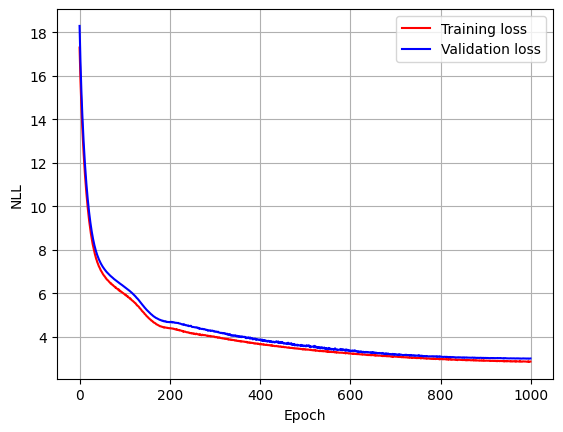

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

# Hyper-parameters
num_epochs = 1000
lr = 1e-3

params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)
hidden_state = np.zeros((hidden_size, 1))
training_loss, validation_loss = [], []

for i in range(num_epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0

    validation_set.inputs, validation_set.targets = shuffle(validation_set.inputs, validation_set.targets, random_state=0)
    for inputs, targets in validation_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        hidden_state = np.zeros_like(hidden_state)
          
        # Forward pass
        # TWOJ KOD TUTAJ!   
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)  # Forward pass
        # Backward pass
        # TWOJ KOD TUTAJ!
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)  # Backward pass
        
        
        epoch_validation_loss += loss

    training_set.inputs, training_set.targets = shuffle(training_set.inputs, training_set.targets, random_state=0)
    for inputs, targets in training_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # TWOJ KOD TUTAJ!
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)  # Forward pass
        
        # Backward pass
        # TWOJ KOD TUTAJ!
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)  # Backward pass
        
        if np.isnan(loss):
            raise ValueError('Gradient zanikł/eksplodował!')
        
        # Update parameters
        # TWOJ KOD TUTAJ!
        params = update_parameters(params, grads, lr=lr)  # Aktualizacja parametrów
        
        epoch_training_loss += loss
        
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


inputs, targets = test_set[1]

inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Ciąg wejściowy:')
print(inputs)

print('\nCiąg wyjściowy:')
print(targets)

print('\nCiąg przewidziany:')
print([idx_to_word[np.argmax(output)] for output in outputs])

epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.grid(visible=True)
plt.show()
    

Poprawna implementacja powinna uzyskać stratę około **4** (przy sumie CE) po 1000 epok.

Teraz, gdy wyszkoliliśmy RNN, czas wystawić go na próbę. Dostarczymy sieci zdanie startowe i zobaczmy jak sobie poradzi!

In [25]:
def generate(params, sentence='', num_generate=10):
    sentence = sentence.split(' ')
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    hidden_state = np.zeros((hidden_size, 1))
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    output_sentence = sentence
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    for i in range(num_generate):
        output = outputs[-1]
        hidden_state = hidden_states[-1]
        output = output.reshape(1, output.shape[0], output.shape[1])
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        word = idx_to_word[np.argmax(outputs)]
        output_sentence.append(word)
        if word == 'EOS':
            break
    return output_sentence


test_examples = ['a a b', 'a a a a b', 'a a a a a a b', 'a', 'r n n']
for i, test_example in enumerate(test_examples):
    print(f'Przykład {i}:', test_example)
    print('Przewidziany ciąg:', generate(params, sentence=test_example), end='\n\n')

Przykład 0: a a b
Przewidziany ciąg: ['a', 'a', 'b', 'b', 'EOS']

Przykład 1: a a a a b
Przewidziany ciąg: ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']

Przykład 2: a a a a a a b
Przewidziany ciąg: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Przykład 3: a
Przewidziany ciąg: ['a', 'a', 'a', 'b', 'EOS']

Przykład 4: r n n
Przewidziany ciąg: ['r', 'n', 'n', 'EOS', 'EOS']



## Implementacja PyTorch

Zrobimy teraz taką samą sieć z wykorzystaniem PyTorcha

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyRecurrentNet(nn.Module):
    def __init__(self, model):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # TWOJ KOD TUTAJ!
        self.rnn = model(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        # Output layer
        self.l_out = nn.Linear(
            in_features=50,
            out_features=vocab_size,
            bias=False
        )
        
    def forward(self, x):
        x, h = self.rnn(x)
        x = x.view(-1, self.rnn.hidden_size)
        x = self.l_out(x)
        return x

net = MyRecurrentNet(nn.LSTM)
print(net)

MyRecurrentNet(
  (rnn): LSTM(4, 50, batch_first=True)
  (l_out): Linear(in_features=50, out_features=4, bias=False)
)


In [47]:
# Hyper-parameters
def run_test(model, num_epochs=200):
    lr = 1e-3

    net = MyRecurrentNet(model)

    # Zdefiniuj funkcję straty i optymalizator dla tego problemu
    # TWOJ KOD TUTAJ!
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    training_loss, validation_loss = [], []

    for i in range(num_epochs):
        
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        net.eval()
            
        for inputs, targets in validation_set:
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)
            
            # Forward pass
            # TWOJ KOD TUTAJ!
            outputs = net(inputs_one_hot)
            
            # Compute loss
            # TWOJ KOD TUTAJ!
            loss = criterion(outputs, targets_idx)
            
            epoch_validation_loss += loss.detach().numpy()
        
        net.train()

        for inputs, targets in training_set:
            
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
            targets_idx = torch.LongTensor(targets_idx)
            
            # Forward pass
            # TWOJ KOD TUTAJ!
            outputs = net(inputs_one_hot)
            
            # Compute loss
            # TWOJ KOD TUTAJ!
            loss = criterion(outputs, targets_idx)
            
            # Backward pass
            # TWOJ KOD TUTAJ!
            # zero grad
            optimizer.zero_grad()
            # backward
            loss.backward()
            
            # step...
            optimizer.step()

            epoch_training_loss += loss.detach().numpy()

        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        if i % 10 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

            
    inputs, targets = test_set[1]

    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
    targets_idx = [word_to_idx[word] for word in targets]
    inputs_one_hot = torch.Tensor(inputs_one_hot)
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

    targets_idx = torch.LongTensor(targets_idx)
    outputs = net.forward(inputs_one_hot).data.numpy()

    print('\nCiąg wejściowy:')
    print(inputs)

    print('\nCiąg wyjściowy:')
    print(targets)

    print('\nCiąg przewidziany:')
    print([idx_to_word[np.argmax(output)] for output in outputs])

    epoch = np.arange(len(training_loss))
    plt.plot(epoch, training_loss, label=f'Training loss of {str(model)}',)
    plt.plot(epoch, validation_loss, label=f'Validation loss of {str(model)}')

**Dodatkowo** zmień sieć RNN na LSTM i GRU zobacz czy osiągniesz lepsze wyniki. Sprawdź co najmniej trzy różne modele!

Epoch 0, training loss: 0.936842260845736, validation loss: 1.3929743766784668
Epoch 10, training loss: 0.6063748392112115, validation loss: 0.5673866593837738
Epoch 20, training loss: 0.6051739378302705, validation loss: 0.5661696803569793
Epoch 30, training loss: 0.6047786941715315, validation loss: 0.5658702635765076
Epoch 40, training loss: 0.6045409591466773, validation loss: 0.5657477331161499

Ciąg wejściowy:
['a', 'a', 'a', 'b', 'b', 'b']

Ciąg wyjściowy:
['a', 'a', 'b', 'b', 'b', 'EOS']

Ciąg przewidziany:
['a', 'a', 'a', 'b', 'b', 'b']
Epoch 0, training loss: 1.0834859402156343, validation loss: 1.3907754039764404
Epoch 10, training loss: 0.6040907725691795, validation loss: 0.5669090676307679
Epoch 20, training loss: 0.6027290403258567, validation loss: 0.5656210136413574
Epoch 30, training loss: 0.6021937140647102, validation loss: 0.5652931988239288
Epoch 40, training loss: 0.6017716775337855, validation loss: 0.5651331162452697

Ciąg wejściowy:
['a', 'a', 'a', 'b', 'b', '

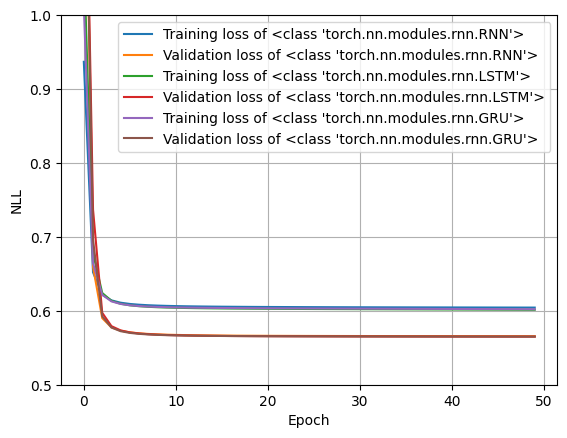

In [48]:
plt.figure()
num_epochs = 50
run_test(nn.RNN, num_epochs)
run_test(nn.LSTM, num_epochs)
run_test(nn.GRU, num_epochs)

plt.ylim(0.50, 1.0)
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

# Zadanie 2 (10pt)

## **1.** Stworzenie sieci rekurencyjnej służącej do generowania tekstu

In [93]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint
import np_utils

Zaimportujemy wybrany plik kodowany jako UTF-8 w formacie txt, będący naszym materiałem do treningu sieci.
Pliki txt, które są w domenie publicznej lub posiadają licencje zezwalające na użytek można uzyskać ze stron:

*   [Projekt Gutenberg](https://www.gutenberg.org/browse/languages/pl)

*   [Wolne Lektury](https://wolnelektury.pl/)

*  [Portal Czytać](https://czytac.com/)

Wybrać po jednym tytule reprezentującym różne gatunki (proza, poezja, dramat).
Załadować wybrany plik reprezentujący prozę.

In [78]:
# Ładowanie pliku tekstowego ze znakami ASCII i konwersja do lowercase 
from keras.utils import get_file


# URL = "https://wolnelektury.pl/media/book/txt/pies-baskervilleow.txt"
# filename = get_file('pies-baskervilleow.txt', origin=URL)

URL = "https://wolnelektury.pl/media/book/txt/pan-tadeusz.txt"
filename = get_file('pan-tadeusz.txt', origin=URL)
raw_original_text = open(filename, 'r', encoding='utf-8').read().lower()
print(len(raw_original_text))

print(raw_original_text[:500])

447334
adam mickiewicz

pan tadeusz
czyli ostatni zajazd na litwie

isbn 978-83-288-2495-9





księga pierwsza



gospodarstwo

powrót panicza — spotkanie się pierwsze w pokoiku, drugie u stołu — ważna sędziego nauka o grzeczności — podkomorzego uwagi polityczne nad modami — początek sporu o kusego i sokoła — żale wojskiego — ostatni woźny trybunału — rzut oka na ówczesny stan polityczny litwy i europy

    litwo! ojczyzno moja! ty jesteś jak zdrowie:
ile cię trzeba cenić, ten tylko się dowie,
kto cię


In [79]:
text = raw_original_text.replace("\n", " ")
split = int(0.9 * len(text))
train_text = text[:split]
test_text = text[split:]

Na początek tak jak już wiemy musimy wprowadzić odpowiednią reprezentacje danych. W tym celu dokonamy zamiany unikalnych znaków występujących w wybranej książce na postać liczbową.

In [80]:
# Tworzenie mapowania unikalnych znaków na postać liczbową 
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 64


In [81]:
max_length = 40
step = 3

def make_sequences(text, max_length=max_length, step=step):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_length, step):
        sequences.append(text[i: i + max_length])
        next_chars.append(text[i + max_length])
    return sequences, next_chars    

sequences, next_chars = make_sequences(train_text)
sequences_test, next_chars_test = make_sequences(test_text, step=10)

print('nb train sequences:', len(sequences))
print('nb test sequences:', len(sequences_test))

nb train sequences: 134187
nb test sequences: 4470


In [82]:
n_sequences = len(sequences)
n_sequences_test = len(sequences_test)
voc_size = len(chars)

# TWOJ KOD TUTAJ!
X = np.zeros((n_sequences, max_length, voc_size), dtype=np.float32)
y = np.zeros((n_sequences, voc_size), dtype=np.float32)

# TWOJ KOD TUTAJ!
X_test = np.zeros((n_sequences_test, max_length, voc_size), dtype=np.float32)
y_test = np.zeros((n_sequences_test, voc_size), dtype=np.float32)


for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
for i, sequence in enumerate(sequences_test):
    for t, char in enumerate(sequence):
        X_test[i, t, char_indices[char]] = 1
    y_test[i, char_indices[next_chars_test[i]]] = 1



In [83]:
def perplexity(y_true, y_pred):
    likelihoods = np.sum(y_pred * y_true, axis=1)
    cross_entropy = -np.mean(np.log2(likelihoods))
    return 2 ** cross_entropy

def model_perplexity(model, X, y, verbose=0):
    predictions = model.predict(X, verbose=verbose)
    return perplexity(y, predictions)

Zdefiniujmy prosty model sieci RNN wykorzystujący jedną warstwę LSTM i 256 komórek

In [84]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(y.shape[1], activation='softmax'))
modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

/home/base/repos/studies/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Zdefiniujmy checkpoint, który może być przydatny w dalszych krokach,
warto do nazwy checkpointa dodać nazwę pliku, na bazie którego sieć jest
 uczona

In [85]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

Przeprowadź trening z wykorzystaniem `batch_size=128` oraz z wykorzystaniem zdefiniowanego powyżej callback'a przez min. 20 epok. Wykorzystaj funkcję categorical 
crossentropy, optimizer ADAM oraz wyświetlaj perplexity na zbiorze 
testowym do oceny modelu w każdej epoce.

In [87]:
from keras.callbacks import LambdaCallback

# Definicja callbacka do obliczania perplexity
def on_epoch_end(epoch, logs):
    test_perplexity = model_perplexity(modelLSTM, X_test, y_test, verbose=0)
    print(f" - test_perplexity: {test_perplexity:.4f}")

perplexity_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Lista callbacków
callbacks_list = [checkpoint, perplexity_callback]

# Trening modelu
modelLSTM.fit(X, y, epochs=50, batch_size=128, callbacks=callbacks_list, verbose=1)

Epoch 1/50
   3/1049 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 2.5128

2024-06-09 16:33:39.612330: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1374074880 exceeds 10% of free system memory.


1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5337
Epoch 1: loss improved from inf to 2.45980, saving model to weights-improvement-01-2.4598.keras
 - test_perplexity: 10.2891
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 2.5336
Epoch 2/50
1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.3156
Epoch 2: loss improved from 2.45980 to 2.28903, saving model to weights-improvement-02-2.2890.keras
 - test_perplexity: 9.2599
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 2.3155
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2050
Epoch 3: loss improved from 2.28903 to 2.18808, saving model to weights-improvement-03-2.1881.keras
 - test_perplexity: 8.5615
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 2.2050
Epoch 4/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.1223
Epoch 4: loss improved from 2.18808 to 2.11070, saving model to weights-improvement-04-2.1107.keras
 - test_perplexity: 8.0201
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step -

In [91]:
# Wybierzmy losowe ziarno będące początkiem generowanej sekwencji
import sys
start = np.random.randint(0, len(sequences)-1)
seed_string = sequences[start]
print("Seed:")
print("\"", seed_string, "\"")

seed_string = "litwo ojczyzno moja ty jestes jak zdrowie"

generated = seed_string
prefix = seed_string
length = 200

for i in range(length):
    x = np.zeros((1, max_length, voc_size))
    shift = max_length - len(prefix)
    for t, char in enumerate(prefix):
        x[0, t + shift, char_indices[char]] = 1.

    preds = modelLSTM.predict(x, verbose=0)
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]
    sys.stdout.write(next_char)
    generated += next_char
    prefix = prefix[1:] + next_char

print("\nKoniec")

Seed:
" ony, *borowik* rozrosły, w drugim związa "
k astwiej maiszy o wygrąmte zgadająz w trup zacztępinęty; nie daserminijenskamineu rzeczy się tam palska zwoiuianki.      jazdlichne zjeciasłek m pimestresz łowczki, zemhrajdną z pokrawior i trzwias w
Koniec


**Dodatkowo** wybierz inne modele sieci wykorzystując inne warstwy, dropout lub kilka warstw np. GRU. Przetestuj przynajmniej trzy różne sieci!

In [103]:
# TWOJ KOD TUTAJ!
def get_models() -> list[Sequential]:
    modelDoubleLSTM = Sequential()
    modelDoubleLSTM.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    modelDoubleLSTM.add(Dropout(0.2))
    modelDoubleLSTM.add(LSTM(256))
    modelDoubleLSTM.add(Dropout(0.2))
    modelDoubleLSTM.add(Dense(y.shape[1], activation='softmax'))
    modelDoubleLSTM.compile(loss='categorical_crossentropy', optimizer='adam')
        
    modelGRU = Sequential()
    modelGRU.add(GRU(256, input_shape=(X.shape[1], X.shape[2])))
    modelGRU.add(Dropout(0.2))
    modelGRU.add(Dense(y.shape[1], activation='softmax'))
    modelGRU.compile(loss='categorical_crossentropy', optimizer='adam')
    
    modelDoubleGRU = Sequential()
    modelDoubleGRU.add(GRU(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    modelDoubleGRU.add(Dropout(0.2))
    modelDoubleGRU.add(GRU(256))
    modelDoubleGRU.add(Dropout(0.2))
    modelDoubleGRU.add(Dense(y.shape[1], activation='softmax'))
    modelDoubleGRU.compile(loss='categorical_crossentropy', optimizer='adam')
    
    modelLSTM = Sequential()
    modelLSTM.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
    modelLSTM.add(Dropout(0.2))
    modelLSTM.add(Dense(y.shape[1], activation='softmax'))
    modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

    return [
        modelLSTM,
        modelDoubleLSTM,
        modelGRU,
        modelDoubleGRU,
    ]


In [108]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

from keras.callbacks import LambdaCallback

def test_model(model: Sequential):
    # Definicja callbacka do obliczania perplexity
    def on_epoch_end(epoch, logs):
        test_perplexity = model_perplexity(model, X_test, y_test, verbose=0)
        print(f" - test_perplexity: {test_perplexity:.4f}")
        
    def print_some_after_seed(seed_string: str):
        print(seed_string)
        generated = seed_string
        prefix = seed_string
        length = 200

        for i in range(length):
            x = np.zeros((1, max_length, voc_size))
            shift = max_length - len(prefix)
            for t, char in enumerate(prefix):
                x[0, t + shift, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)
            next_index = np.argmax(preds)
            next_char = indices_char[next_index]
            sys.stdout.write(next_char)
            generated += next_char
            prefix = prefix[1:] + next_char

        

    print("Model layers:", model.layers)
    perplexity_callback = LambdaCallback(on_epoch_end=on_epoch_end)
    # Lista callbacków
    callbacks_list = [checkpoint, perplexity_callback]
    # Trening modelu
    model.fit(X, y, epochs=30, batch_size=128, callbacks=callbacks_list, verbose=1)

    # Wybierzmy losowe ziarno będące początkiem generowanej sekwencji
    import sys
    start = np.random.randint(0, len(sequences)-1)
    seed_string = sequences[start]
    print_some_after_seed(seed_string)
    
    seed_string = "litwo ojczyzno moja ty jestes jak zdrowie"
    print_some_after_seed(seed_string)


In [109]:
modelDoubleLSTM = Sequential()
modelDoubleLSTM.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
modelDoubleLSTM.add(Dropout(0.2))
modelDoubleLSTM.add(LSTM(256))
modelDoubleLSTM.add(Dropout(0.2))
modelDoubleLSTM.add(Dense(y.shape[1], activation='softmax'))
modelDoubleLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

test_model(modelDoubleLSTM)

/home/base/repos/studies/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model layers: [<LSTM name=lstm_34, built=True>, <Dropout name=dropout_64, built=True>, <LSTM name=lstm_35, built=True>, <Dropout name=dropout_65, built=True>, <Dense name=dense_41, built=True>]
Epoch 1/30


2024-06-09 21:05:55.115306: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1374074880 exceeds 10% of free system memory.


1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.9945
Epoch 1: loss improved from inf to 2.68294, saving model to weights-improvement-01-2.6829.keras
 - test_perplexity: 10.3790
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - loss: 2.9939
Epoch 2/30
1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.3094
Epoch 2: loss improved from 2.68294 to 2.27069, saving model to weights-improvement-02-2.2707.keras
 - test_perplexity: 8.8134
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step - loss: 2.3093
Epoch 3/30
1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.1507
Epoch 3: loss improved from 2.27069 to 2.12997, saving model to weights-improvement-03-2.1300.keras
 - test_perplexity: 7.8843
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 87s 83ms/step - loss: 2.1507
Epoch 4/30
1048/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.0413
Epoch 4: loss improved from 2.12997 to 2.02493, saving model to weights-improvement-04-2.0249.keras
 - test_perplexity: 7.2701
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step -

In [ ]:
modelGRU = Sequential()
modelGRU.add(GRU(256, input_shape=(X.shape[1], X.shape[2])))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(y.shape[1], activation='softmax'))
modelGRU.compile(loss='categorical_crossentropy', optimizer='adam')

test_model(modelGRU)

In [ ]:
modelDoubleGRU = Sequential()
modelDoubleGRU.add(GRU(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
modelDoubleGRU.add(Dropout(0.2))
modelDoubleGRU.add(GRU(256))
modelDoubleGRU.add(Dropout(0.2))
modelDoubleGRU.add(Dense(y.shape[1], activation='softmax'))
modelDoubleGRU.compile(loss='categorical_crossentropy', optimizer='adam')

test_model(modelDoubleGRU)

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(y.shape[1], activation='softmax'))
modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

test_model(modelLSTM)